# Text Detection

Detect Text Labels in OAAM Functions Layer and generally in block-diagrams. Outputs bounding boxes and texts. 

In [8]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pytesseract
from pytesseract import Output
import pandas as pd
import pprint

## Input

In [9]:
# Define the paths
# target_image_path = 'many_tasks.png'
# target_image_path = 'many_tasks_some_connections_2.png' # breaking case, OCR does not find Output 01 and Input 05
# target_image_path = 'door_system_after_preprocessing_big.png'
# target_image_path = '3boxes_grey_input.png'
# target_image_path = '00_3boxes_labels_scaled_unknown.png'
target_image_path = 'images/testcase6.png'

target_img = cv2.imread(target_image_path)

#### Visualization of Input

In [10]:
# # Draw target image image
# fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# ax.imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
# ax.set_title('Target Image')
# plt.show()

## Grayscale
Currently, only grayscale is used, not thresholded

In [11]:
# Convert to grayscale
target_gray = cv2.cvtColor(target_img, cv2.COLOR_BGR2GRAY)

# Threshold the template image
_, target_thresh = cv2.threshold(target_gray, 245, 255, cv2.THRESH_BINARY_INV)

#### Visualize Grayscale

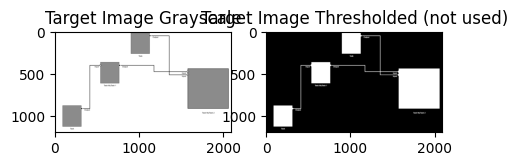

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(5, 5))
ax[0].imshow(target_gray, cmap='gray')
ax[0].set_title('Target Image Grayscale')
ax[1].imshow(target_thresh, cmap='gray')
ax[1].set_title('Target Image Thresholded (not used)')
plt.show()

## Tesseract OCR
#### General Configuration
Good overview on page segmentation modes [Py image search](https://pyimagesearch.com/2021/11/15/tesseract-page-segmentation-modes-psms-explained-how-to-improve-your-ocr-accuracy/)

In [13]:
# Configuration strings for pytesseract
config_psm = '--psm 11'
config_oem = '--oem 3'  # Default is 3 for both LSTM and legacy engine
# config_chars = '-c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789!@#$%^&*()_+=-[]{}|;:<>/? '
# config_chars = '-c tessedit_char_blacklist=T‘O'
# print(config_chars)

# Combine the configurations
custom_config = f'{config_psm} {config_oem}'
# custom_config = f'{config_psm} {config_oem} {config_chars}'

# 6 works, but is made for single uniform block of text
# 11 works 99%, made for sparse text

#### Image to Text (Debug only)
Actual output happens in Image to Data

In [14]:
text = pytesseract.image_to_string(target_gray, config=custom_config)# Replace newlines with spaces to make it a single line
formatted_text = text.replace("\n\n", " | ")
print(formatted_text)

Output | Task | Input | Output | Input | Task MyTask 1 | Output | Task MyTask 2 | Task



## Image to Data
This is only for testing if rotated text can also be read

In [15]:
data = pytesseract.image_to_data(target_gray, output_type=Output.DICT, config=custom_config)
# draw the data as a nice panda dataframe
pd.set_option('display.width', 200)  # None should be not limit, but for some reason defaults to 80. So manually set high value. 
pd.set_option('display.max_rows', None)  # Don't truncate rows, Jupyter notebook will handle this anyways

df = pd.DataFrame(data)
print(df)
# Rotate the image by 90 degrees
rotated_img = cv2.rotate(target_img, cv2.ROTATE_90_CLOCKWISE)
rotated_gray = cv2.cvtColor(rotated_img, cv2.COLOR_BGR2GRAY)

# Perform OCR on the rotated image
rotated_data = pytesseract.image_to_data(rotated_gray, output_type=Output.DICT, config=custom_config)

# Rotate the OCR data back to the original orientation
for i in range(len(rotated_data['text'])):
    x, y, w, h = rotated_data['left'][i], rotated_data['top'][i], rotated_data['width'][i], rotated_data['height'][i]
    rotated_data['left'][i] = y
    rotated_data['top'][i] = rotated_img.shape[1] - (x + w)
    rotated_data['width'][i] = h
    rotated_data['height'][i] = w

# Combine the original and rotated OCR data
for key in data.keys():
    data[key].extend(rotated_data[key])

# Update the dataframe with the combined data
df = pd.DataFrame(data)
print(df)

    level  page_num  block_num  par_num  line_num  word_num  left   top  width  height  conf    text
0       1         1          0        0         0         0     0     0   2091    1188    -1        
1       2         1          1        0         0         0  1154    65     66      20    -1        
2       3         1          1        1         0         0  1154    65     66      20    -1        
3       4         1          1        1         1         0  1154    65     66      20    -1        
4       5         1          1        1         1         1  1154    65     66      20    96  Output
5       2         1          2        0         0         0   987   286     45      16    -1        
6       3         1          2        1         0         0   987   286     45      16    -1        
7       4         1          2        1         1         0   987   286     45      16    -1        
8       5         1          2        1         1         1   987   286     45      16    9

#### Visualize OCR Result

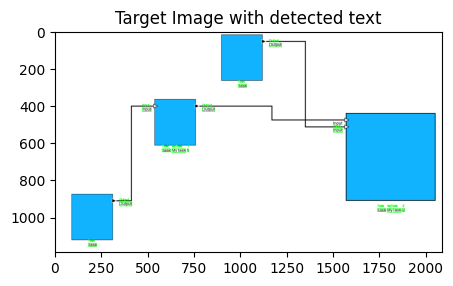

In [16]:
# Draw the bounding boxes
plot_img = target_img.copy()
n_boxes = len(data['text'])
for i in range(n_boxes):
    if int(data['conf'][i]) > 0: # only text has a confidence value, so basically filters for text
        (x, y, w, h) = (data['left'][i], data['top'][i], data['width'][i], data['height'][i])
        plot_img = cv2.rectangle(plot_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # put text
        plot_img = cv2.putText(plot_img, data['text'][i], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Draw target image image
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(cv2.cvtColor(plot_img, cv2.COLOR_BGR2RGB))
ax.set_title('Target Image with detected text')
plt.show()

# doc for pandas options
# pd.describe_option('display')


#### Histogram of confidence

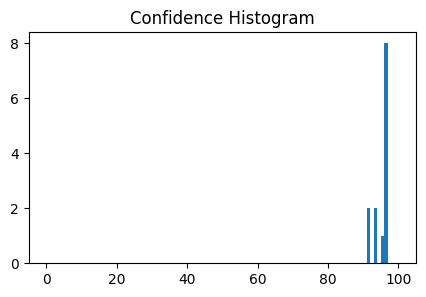

In [17]:
# plot the confidences in a histogram
fig, ax = plt.subplots(figsize=(5, 3))
ax.hist(df['conf'], bins=100, range=(0, 100))
ax.set_title('Confidence Histogram')
plt.show()

## Processing
From raw word boxes to someething useful

#### Merge single Words into Text Labels
Group neighboring words together to labels. Keep confidence for further processing. 

* expected format: 
* [1157, 295, 146, 13, 'Task Actor Locked ', 96]
* left, top, widht, height, text, confidence

In [18]:
# merge single words to blocks which represent a text label
text_boxes = []
for textbox in range(len(data['text'])):  # iterate over the data
    level = data['level'][textbox]  # get the level of the current data
    if level == 2:  # if the level is 2, then it is a block. All our labels are words grouped in a block. (and line and paragraph)
        # store the bounding box, prepare an empty text string, untouched confidence is 100
        # format: left, top, width, height, text, confidence
        text_boxes.append( [data['left'][textbox], data['top'][textbox], data['width'][textbox], data['height'][textbox], "", 100] )
    elif level == 5:
        # add the text to the last block, position 4 is text
        text_boxes[-1][4] = text_boxes[-1][4] + data['text'][textbox] + " "
        # confidence is worst of old and new, position 5 is confidence
        text_boxes[-1][5] = min(text_boxes[-1][5], data['conf'][textbox])

print(text_boxes)

[[1154, 65, 66, 20, 'Output ', 96], [987, 286, 45, 16, 'Task ', 95], [470, 412, 48, 20, 'Input ', 96], [794, 412, 66, 20, 'Output ', 96], [1500, 524, 48, 20, 'Input ', 96], [577, 633, 142, 20, 'Task MyTask 1 ', 91], [347, 920, 66, 20, 'Output ', 96], [1738, 954, 145, 20, 'Task MyTask 2 ', 91], [179, 1141, 45, 16, 'Task ', 96]]


#### Remove trailing space

In [19]:
# remove the trailing space from the text, e.g. 'Output '
for textbox in text_boxes:
    textbox[4] = textbox[4].strip()
print(text_boxes)

[[1154, 65, 66, 20, 'Output', 96], [987, 286, 45, 16, 'Task', 95], [470, 412, 48, 20, 'Input', 96], [794, 412, 66, 20, 'Output', 96], [1500, 524, 48, 20, 'Input', 96], [577, 633, 142, 20, 'Task MyTask 1', 91], [347, 920, 66, 20, 'Output', 96], [1738, 954, 145, 20, 'Task MyTask 2', 91], [179, 1141, 45, 16, 'Task', 96]]


#### Remove too big (height) text
Typically, this is blocks detected as text. So filter such that text labels have a limited height. Actually this filtering might make sense earlier? 

In [20]:
# MAX_HEIGHT = 100
# # remove text boxes which are too big
# original_number_of_text_boxes = len(text_boxes)
# text_boxes = [textbox for textbox in text_boxes if textbox[3] < MAX_HEIGHT]
# print(f"Removed {original_number_of_text_boxes - len(text_boxes)} text boxes because they were too big. ") # debug message
# print(text_boxes)

#### Remove single non-text character blocks

In [21]:
forbidden_chars = ['<','.','>',',','/',';',':','\'','"','[',']','{','}','|','\\','`','~','!','^','(',')','_','-','+','=']
# remove text boxes which have as text only a forbidden character
original_number_of_text_boxes = len(text_boxes)
text_boxes = [textbox for textbox in text_boxes if textbox[4] not in forbidden_chars]
print(f"Removed {original_number_of_text_boxes - len(text_boxes)} text boxes because they were forbidden characters. ") # debug message
print(text_boxes)

Removed 0 text boxes because they were forbidden characters. 
[[1154, 65, 66, 20, 'Output', 96], [987, 286, 45, 16, 'Task', 95], [470, 412, 48, 20, 'Input', 96], [794, 412, 66, 20, 'Output', 96], [1500, 524, 48, 20, 'Input', 96], [577, 633, 142, 20, 'Task MyTask 1', 91], [347, 920, 66, 20, 'Output', 96], [1738, 954, 145, 20, 'Task MyTask 2', 91], [179, 1141, 45, 16, 'Task', 96]]


#### Write out worst confidence
Might be good for debugging.

In [22]:
# get the worst confidence
worst_confidence = min([textbox[5] for textbox in text_boxes])
print(f"Tesseract OCR: worst text remaining detection confidence is {worst_confidence}.") # info message

Tesseract OCR: worst text remaining detection confidence is 91.


#### Visualize Remaining Text Blocks = Labels

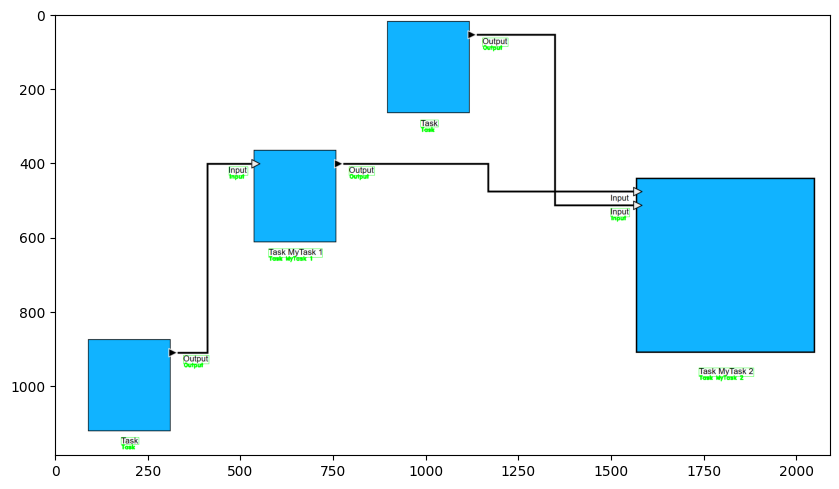

In [23]:
# Draw the merged bounding boxes on the image
img_bbox_blocks = target_img.copy()
for (x, y, w, h, text, conf) in text_boxes:
    cv2.rectangle(img_bbox_blocks, (x-1, y-1), (x + w + 2, y + h + 2), (0, 255, 0), 1)
    cv2.putText(img_bbox_blocks, text, (x, y + 30), cv2.FONT_HERSHEY_DUPLEX , 0.5, (0, 255, 0), 2)

# Plot the merged bounding boxes
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(cv2.cvtColor(img_bbox_blocks, cv2.COLOR_BGR2RGB))

plt.show()

# Appendix, currently not relevant
Here only for historic reasons 
* .
*
*
*
*
*
*
*
*
*
*
*

### Filter

{'block_num': [1, 2, 3, 4, 5, 6, 6, 6, 7, 8, 8, 8, 9],
 'conf': [96, 95, 96, 96, 96, 93, 91, 96, 96, 93, 91, 96, 96],
 'height': [20, 16, 20, 20, 20, 16, 20, 16, 20, 16, 20, 16, 16],
 'left': [1154, 987, 470, 794, 1500, 577, 630, 713, 347, 1738, 1791, 1872, 179],
 'level': [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
 'line_num': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'page_num': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'par_num': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'text': ['Output',
          'Task',
          'Input',
          'Output',
          'Input',
          'Task',
          'MyTask',
          '1',
          'Output',
          'Task',
          'MyTask',
          '2',
          'Task'],
 'top': [65, 286, 412, 412, 524, 633, 633, 633, 920, 954, 954, 954, 1141],
 'width': [66, 45, 48, 66, 48, 45, 74, 6, 66, 45, 74, 11, 45],
 'word_num': [1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 2, 3, 1]}


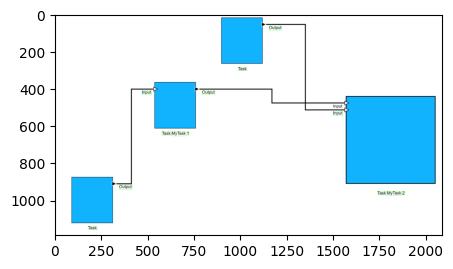

In [24]:
# Filter the detected text and their bounding boxes for a confidence threshold
confidence_threshold = 60
filtered_data = {key: [value[i] for i in range(len(data['conf'])) if data['conf'][i] > confidence_threshold] for key, value in data.items()}
pprint.pprint(filtered_data)

# Draw the bounding boxes on the image
bbox_img = target_img.copy()
for textbox in range(len(filtered_data['text'])):
    (x, y, w, h) = (filtered_data['left'][textbox], filtered_data['top'][textbox], filtered_data['width'][textbox], filtered_data['height'][textbox])
    cv2.rectangle(bbox_img, (x-1, y-1), (x + w + 2, y + h + 2), (0, 255, 0), 1) # bounding boxes 1 pixel larger than the detected text
    # print(f"Detected text: {filtered_data['text'][i]} (Confidence: {filtered_data['conf'][i]}%)")

# Plot the bounding boxes
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(cv2.cvtColor(bbox_img, cv2.COLOR_BGR2RGB))
plt.show()


### Merge Word Boxes to String Boxes

[[1154, 65, 66, 20, 'Output'], [987, 286, 45, 16, 'Task'], [470, 412, 48, 20, 'Input'], [794, 412, 66, 20, 'Output'], [1500, 524, 48, 20, 'Input'], [577, 633, 45, 16, 'Task'], [630, 633, 74, 20, 'MyTask'], [713, 633, 6, 16, '1'], [347, 920, 66, 20, 'Output'], [1738, 954, 45, 16, 'Task'], [1791, 954, 92, 20, 'MyTask 2'], [179, 1141, 45, 16, 'Task']]


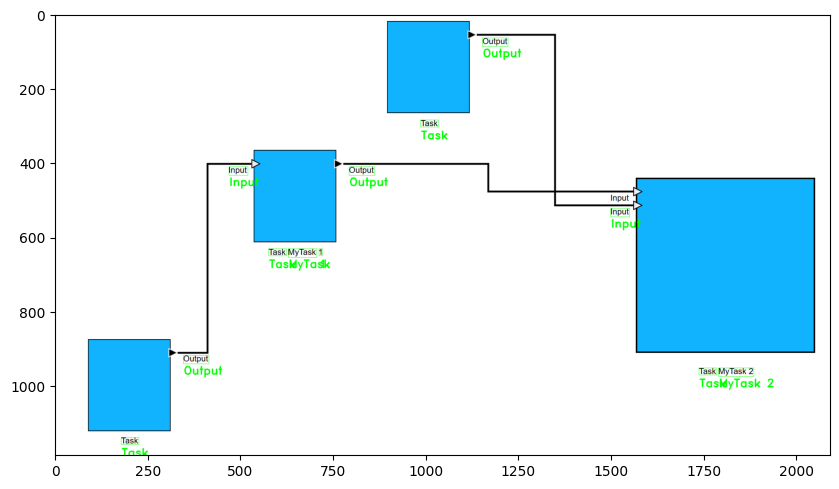

In [25]:
def merge_adjacent_boxes(data, horizontal_threshold=7, vertical_threshold=1):
    """
    Merge bounding boxes that are adjacent and aligned vertically within specified thresholds.

    Parameters:
    - data: Dictionary containing 'left', 'top', 'width', 'height', and 'text' of bounding boxes.
    - horizontal_threshold: Maximum horizontal gap between boxes to consider them adjacent.
    - vertical_threshold: Maximum vertical difference to consider boxes on the same line.

    Returns:
    - List of merged boxes with format [x, y, w, h, text].
    """
    merged_boxes = []

    for i, text in enumerate(data['text']):
        x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
        # print(f"Processing box {i} with text: {text}")
        # print(f"Box {i} coordinates: ({x}, {y}, {w}, {h})")

        # Attempt to merge with the last box in merged_boxes if not empty
        if merged_boxes:
            last_box = merged_boxes[-1]
            last_box_right_edge = last_box[0] + last_box[2]
            last_box_bottom_edge = last_box[1] + last_box[3]

            # Check if current box is adjacent and vertically aligned with the last box
            if (x <= last_box_right_edge + horizontal_threshold and
                    abs(y - last_box[1]) <= vertical_threshold):
                # Merge current box with the last box
                new_right_edge = max(last_box_right_edge, x + w)
                new_bottom_edge = max(last_box_bottom_edge, y + h)
                last_box[2] = new_right_edge - last_box[0]  # Update width
                last_box[3] = new_bottom_edge - last_box[1]  # Update height
                last_box[4] += " " + text  # Concatenate text
            else:
                # Add as a new box if not adjacent/aligned
                merged_boxes.append([x, y, w, h, text])
        else:
            # Add the first box
            merged_boxes.append([x, y, w, h, text])

    return merged_boxes

merged_boxes = merge_adjacent_boxes(filtered_data)
print(merged_boxes)

# Draw the merged bounding boxes on the image
img_bbox_merge = target_img.copy()
for (x, y, w, h, text) in merged_boxes:
    cv2.rectangle(img_bbox_merge, (x-1, y-1), (x + w + 2, y + h + 2), (0, 255, 0), 1)
    cv2.putText(img_bbox_merge, text, (x, y + 50), cv2.FONT_HERSHEY_DUPLEX , 1, (0, 255, 0), 2)

# Plot the merged bounding boxes
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(cv2.cvtColor(img_bbox_merge, cv2.COLOR_BGR2RGB))
plt.show()
